<a href="https://colab.research.google.com/github/LeNovice/Assignments_WILP_SEM3/blob/main/Main_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Refer

https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/

Data Pipeline:
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

Loading the Caltech Dataset

In [20]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model buildingZ
from tensorflow.keras import models

Code to get the number of samples per class

Initially we will only try to train for 10 classes.

https://github.com/tensorflow/datasets/issues/1923#issuecomment-1361608072

In [21]:
NUM_CLASSES = 10
DataSet = 'caltech101'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        #class_hist[val] = count
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:NUM_CLASSES]
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [22]:
(ds, ds_info) = tfds.load(DataSet, with_info=True, as_supervised=True)

In [23]:
#ds_train, train_info = ds["train"], ds_info.splits['train']
#ds_test, test_info = ds["test"], ds_info.splits['test']

ds_train, train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
ds_test, test_info = tfds.load(DataSet, split='test[25%:]', with_info=True, as_supervised=True)

In [24]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
display(class_list)
class_list.sort()
display(class_list)
filtered_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
filtered_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))


[66, 1, 4, 38, 37, 95, 57, 9, 16, 54]

[1, 4, 9, 16, 37, 38, 54, 57, 66, 95]

In [25]:
num_samples_per_class(filtered_ds_train, print_all=True)

1 608
4 355
9 106
16 104
37 335
38 336
54 91
57 152
66 621
95 197


[]

In [26]:
num_samples_per_class(filtered_ds_test, print_all=True)

1 581
4 324
9 72
16 67
37 310
38 296
54 63
57 136
66 568
95 151


[]

Data Preprocessing

We could use adapt() methods to get normlazation (feature wise) parameters. https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method

https://stackoverflow.com/questions/57657386/tensorflow-datasets-reshape-images


MAINLY:
https://www.tensorflow.org/datasets/keras_example

In [27]:
#Hyperparameters
IMG_SIZE = 224
NUM_CHANNELS = 3
BATCH_SIZE=128


Resizing and re-scaling images to a given dataset.
Tutorial used: https://www.tensorflow.org/tutorials/images/data_augmentation

For data pipeline you may also refer to
https://github.com/tensorflow/datasets/issues/720

In [28]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64),
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

@tf.function
def map_func(label):
    global class_list
    mapped_label = table.lookup(label)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#buffer_size = ds_info.splits['train'].num_examples      #Might return -2   https://stackoverflow.com/questions/50737192/tf-data-dataset-how-to-get-the-dataset-size-number-of-elements-in-an-epoch
buffer_size = 30*NUM_CLASSES

#resized_ds_train = filtered_ds_train.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
#https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
def prepare(ds, shuffle=False, augment=False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resized_ds_train = prepare(filtered_ds_train, augment=True)
resized_ds_test = prepare(filtered_ds_test)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("None_Lookup/LookupTableFindV2:0", shape=(), dtype=int64)


In [30]:
num_samples_per_class(resized_ds_train, print_all=True)

0 2432
1 1420
2 424
3 416
4 1340
5 1344
6 364
7 608
8 2484
9 788


[]

In [31]:
num_samples_per_class(resized_ds_test, print_all=True)

0 581
1 324
2 72
3 67
4 310
5 296
6 63
7 136
8 568
9 151


[]

display few examples

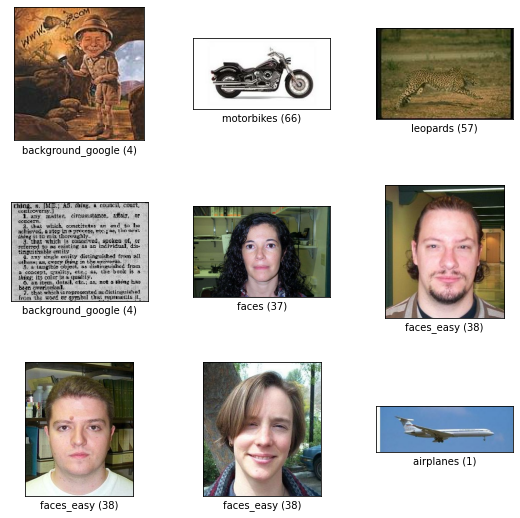

In [32]:
fig = tfds.show_examples(filtered_ds_train, ds_info)

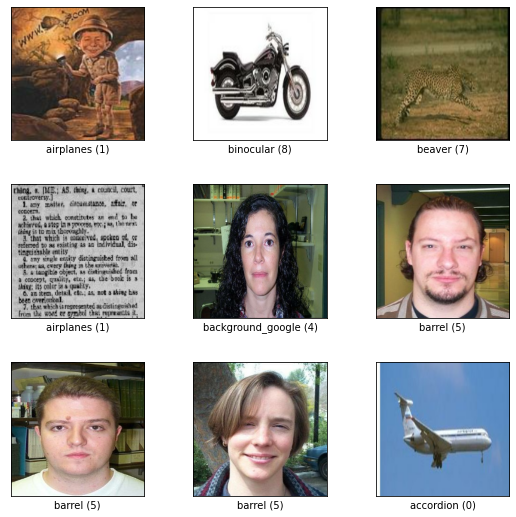

In [33]:
#ds_example = ds_train.take(10)
fig = tfds.show_examples(resized_ds_train, ds_info)

Prepare the model
For Batchnorm, refer https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

Here they say that During training, the layer normalizes its output using the mean and standard deviation of the **current batch** of inputs.

In order to make BatchNorm great, should we be using a larger batch as input?

However, during Inference mode, the mean ans tsd deviation does not correspond to the current batch. Rather it is a moving mean and std dev of all the bacthes seen in training phase. (Thus, the parameters in inference phase for batch norm do not change)

In [34]:
input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)

In [35]:
model = models.Sequential()
#model.add(resize_and_rescale)

kernel_size = (5,5)
model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(192, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(64, kernel_size))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(128, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [36]:
Learning_Rate = 1e-1                                            #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
model.compile( optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 192)     110784    
                                                                 
 batch_normalization_5 (Batc  (None, 108, 108, 192)    768       
 hNormalization)                                                 
                                                      

Reference: https://github.com/tensorflow/datasets/issues/720

In [37]:
#resized_ds_train = resized_ds_train.cache()

#resized_ds_train = resized_ds_train.shuffle(buffer_size)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)
#resized_ds_train = resized_ds_train.prefetch(tf.data.AUTOTUNE)

Evaluation

In [38]:
h = model.fit( resized_ds_train, epochs=10)

Epoch 1/10
91/91 [==============================] - 98s 1s/step - loss: 43.2803 - accuracy: 0.4833
Epoch 2/10
91/91 [==============================] - 94s 1s/step - loss: 4.4528 - accuracy: 0.6243
Epoch 3/10
91/91 [==============================] - 93s 1s/step - loss: 2.6878 - accuracy: 0.6676
Epoch 4/10
91/91 [==============================] - 93s 1s/step - loss: 1.8653 - accuracy: 0.6875
Epoch 5/10
91/91 [==============================] - 94s 1s/step - loss: 1.5779 - accuracy: 0.7105
Epoch 6/10
91/91 [==============================] - 93s 1s/step - loss: 1.8142 - accuracy: 0.7045
Epoch 7/10
91/91 [==============================] - 93s 1s/step - loss: 1.9331 - accuracy: 0.7114
Epoch 8/10
91/91 [==============================] - 94s 1s/step - loss: 1.4734 - accuracy: 0.7355
Epoch 9/10
91/91 [==============================] - 92s 1s/step - loss: 1.6797 - accuracy: 0.7417
Epoch 10/10
91/91 [==============================] - 92s 1s/step - loss: 1.4919 - accuracy: 0.7546


In [39]:
loss,acc = model.evaluate(resized_ds_test)

21/21 [==============================] - 6s 264ms/step - loss: 1.1124 - accuracy: 0.7921
